In [6]:
import sys
sys.path.append("../")
from ia_kdsb17.image_prep import unet
from ia_kdsb17.image_prep import helpers as imhelpers
from itertools import starmap
import matplotlib.pyplot as plt
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import numpy as np

In [7]:
def extract_roi(img):
    rows, cols = img.shape
    mean = np.mean(img)
    max = np.max(img)
    min = np.min(img)
    
    img[img == max] = mean
    img[img == min] = mean
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(img, [np.prod(img.shape), 1]))
    centers = sorted(kmeans.cluster_centers_.flatten())

    threshold = np.mean(centers)
    thresh_img = np.where(img < threshold, 1.0, 0.0)  # threshold the image

    eroded = morphology.erosion(thresh_img, np.ones([3, 3]))
    dilation = morphology.dilation(eroded, np.ones([10, 10]))

    labels = measure.label(dilation)
    label_vals = np.unique(labels)

    regions = measure.regionprops(labels)
    good_labels = []
    
    for prop in regions:
        B = prop.bbox
        if B[2] - B[0] < 475 and B[3] - B[1] < 475 and B[0] > 40 and B[2] < 472:
            good_labels.append(prop.label)

    mask = np.ndarray([rows, cols], dtype=np.int8)
    mask[:] = 0
    
    for N in good_labels:
        mask = mask + np.where(labels == N, 1, 0)
        
    if (mask == 1).sum() < 26214:
        return None

    mask = morphology.dilation(mask, np.ones([10, 10]))  # one last dilation

    img_masked = img * mask
    new_mean = np.mean(img_masked[mask > 0])
    new_std = np.std(img_masked[mask > 0])
    old_min = np.min(img_masked)
    img_masked[img_masked == old_min] = new_mean - 1.2 * new_std  # resetting backgound color
    img_masked = img_masked - new_mean
    img_masked = img_masked / new_std

    labels = measure.label(mask)
    regions = measure.regionprops(labels)

    min_row = 512
    max_row = 0
    min_col = 512
    max_col = 0
    for prop in regions:
        B = prop.bbox
        if min_row > B[0]:
            min_row = B[0]
        if min_col > B[1]:
            min_col = B[1]
        if max_row < B[2]:
            max_row = B[2]
        if max_col < B[3]:
            max_col = B[3]
    width = max_col - min_col
    height = max_row - min_row
    if width > height:
        max_row = min_row + width
    else:
        max_col = min_col + height

    imgc = img_masked[min_row:max_row, min_col:max_col]
    maskc = mask[min_row:max_row, min_col:max_col]

    if max_row - min_row < 5 or max_col - min_col < 5:  # skipping all images with no god regions
        return None
    else:
        mean = np.mean(imgc)
        imgc = imgc - mean
        min = np.min(imgc)
        max = np.max(imgc)
        imgc = imgc / (max - min)
        new_img = resize(imgc, [512, 512], mode='constant')

        return new_img

In [8]:
data_dir = '../data/small'
stream = imhelpers.image_dirs(data_dir)
stream = starmap(imhelpers.list_images_for_patient, stream)
stream = starmap(lambda path, patient, im_list: (path, patient, filter(lambda x: len(x) > 0, im_list)), stream)
stream = starmap(imhelpers.load_dicoms, stream)
stream = starmap(lambda p, idd, d: (p, idd, imhelpers.dicom_to_z_pixel(d)), stream)
stream = starmap(lambda p, idd, d: (p, idd, imhelpers.sort_images(d)), stream)
stream = imhelpers.flat_starmap(lambda p, idd, z_ims: starmap(lambda z, im: (p, idd, im), z_ims), stream)
stream = starmap(lambda p, idd, im: (p, idd, unet.standardize(im)), stream)
stream = starmap(lambda p, idd, im: (p, idd, extract_roi(im)), stream)
stream = filter(lambda x: x[2] is not None, stream)

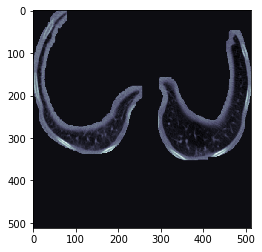

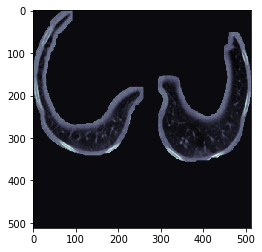

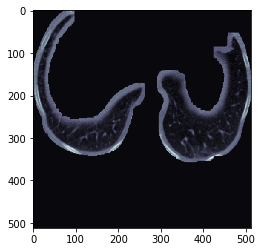

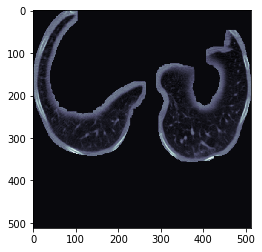

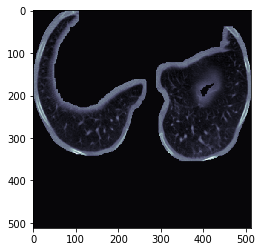

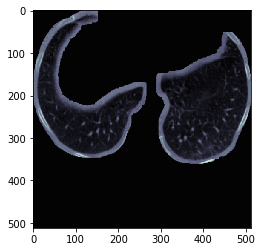

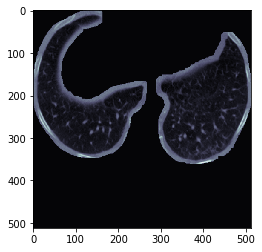

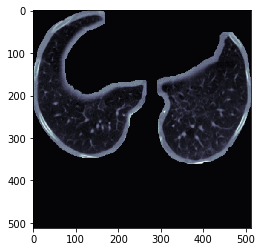

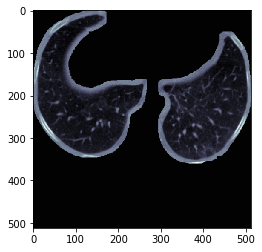

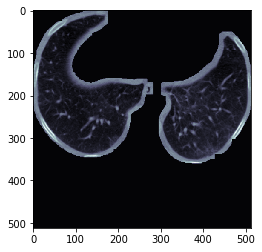

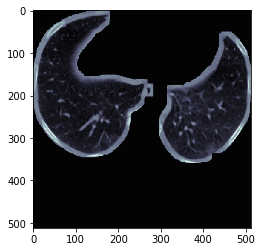

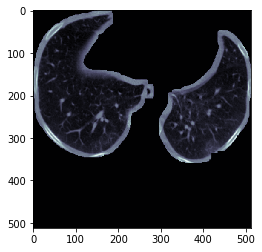

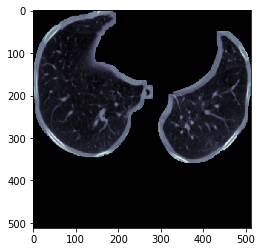

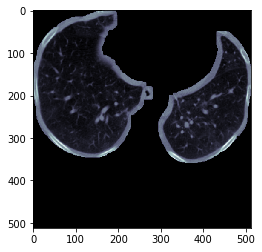

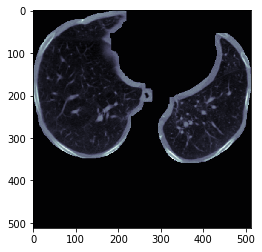

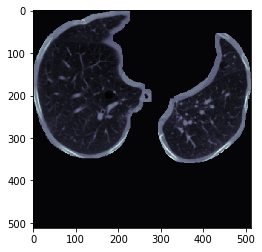

KeyboardInterrupt: 

In [9]:
for item in stream:
    path, idd, image = item
    if image is not None:
        plt.imshow(image, cmap='bone')
        plt.show()
    else:
        print("no ROIS")
    